In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle

In [2]:
with open('cal_pickle.p', 'rb') as f:
    file = pickle.load(f)
    
mtx = file['mtx']
dist = file['dist']

In [3]:
def undistort(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

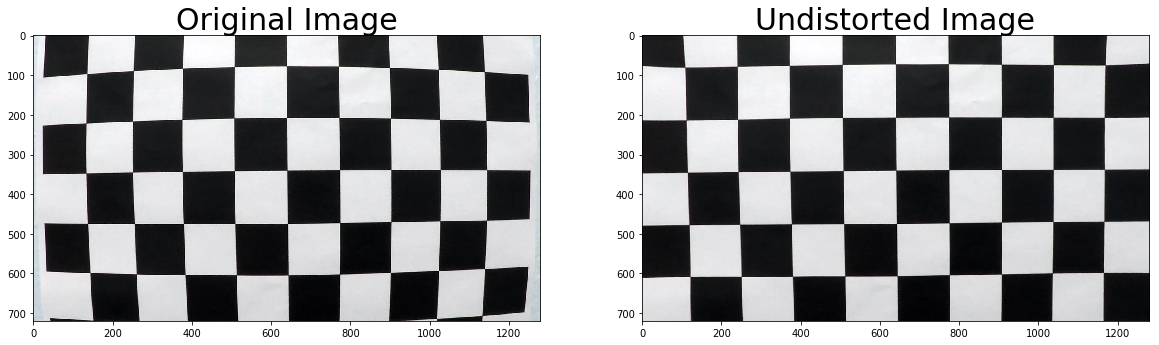

In [4]:
img = cv2.imread('calibration1.jpg')
dst = undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

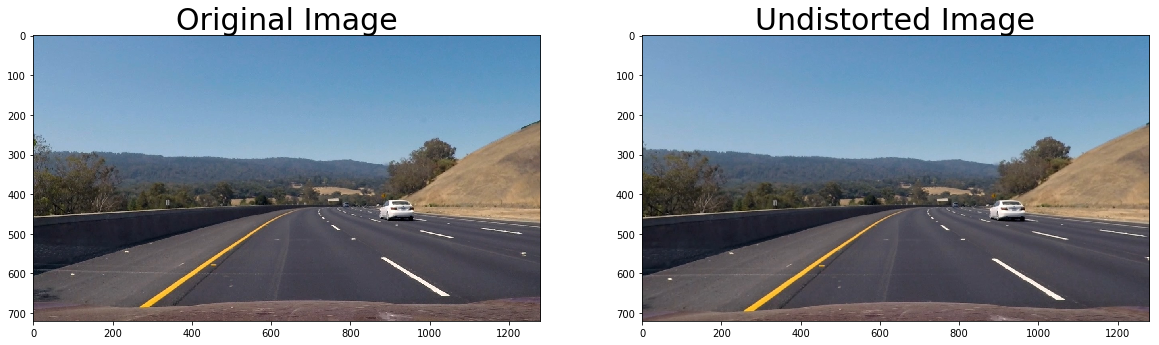

In [5]:
img = cv2.imread('test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

## detect edges using sobel

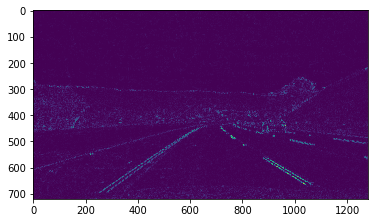

In [6]:
undistort_img = undistort(img)

hls = cv2.cvtColor(undistort_img, cv2.COLOR_RGB2HLS).astype(np.float)
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]
h_channel = hls[:,:,0]

sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 1)
abs_sobelx = np.absolute(sobelx)
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

plt.imshow(scaled_sobel)

## to get negative pixels from the edges

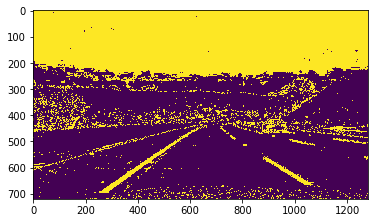

In [7]:
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= 15) & (scaled_sobel <= 255)] = 1
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= 100) & (s_channel <= 255)] = 1
color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

plt.imshow(combined_binary * 255)

In [8]:
h, w, d = img.shape
np.array((w, h))

array([1280,  720])

In [9]:
lanes = np.float32([(0.43,0.65),(0.58,0.65),(0.1,1),(1,1)]) * np.float32((w, h))
lanes_int = lanes.astype(np.int32)
lanes_int

array([[ 550,  467],
       [ 742,  467],
       [ 128,  720],
       [1280,  720]], dtype=int32)

In [10]:
lanes_int[-1]

array([1280,  720], dtype=int32)

1. top left
2. top right
3. bottom left
4. bottom right

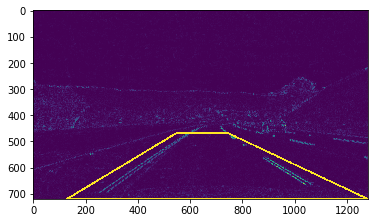

In [11]:
copied = np.copy(scaled_sobel)
cv2.line(copied,tuple(lanes_int[-2]),tuple(lanes_int[-1]), (255, 0, 0), 5)
cv2.line(copied,tuple(lanes_int[-1]),tuple(lanes_int[1]), (255, 0, 0), 5)
cv2.line(copied,tuple(lanes_int[0]),tuple(lanes_int[-2]), (255, 0, 0), 5)
cv2.line(copied,tuple(lanes_int[0]),tuple(lanes_int[1]), (255, 0, 0), 5)
plt.imshow(copied)

In [12]:
src = np.float32([(0,0), (1, 0), (0,1), (1,1)])
src = src * np.float32((w, h))

M = cv2.getPerspectiveTransform(lanes, src)
M

array([[-8.04597882e-01, -1.34865922e+00,  1.07402317e+03],
       [-5.32907052e-16, -2.06896573e+00,  9.68275899e+02],
       [-6.71505838e-19, -2.39463624e-03,  1.00000000e+00]])

In [13]:
warped = cv2.warpPerspective(combined_binary, M, (w, h))
warped.shape

(720, 1280)

Text(0.5, 1.0, 'Warped Image')

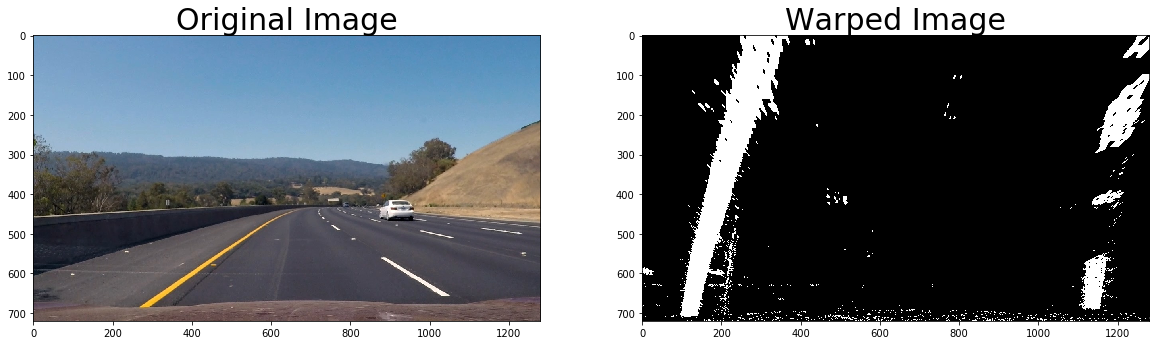

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=30)

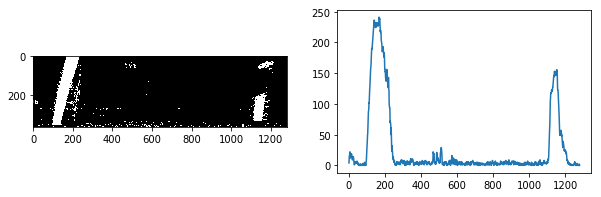

In [15]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.imshow(warped[warped.shape[0]//2:,:], cmap='gray')
ax2.plot(histogram)
plt.show()

In [16]:
warped_3d = np.dstack((warped, warped, warped))*255
midpoint = histogram.shape[0]//2
left_peak = np.argmax(histogram[:midpoint])
right_peak = np.argmax(histogram[midpoint:]) + midpoint

In [17]:
left_peak, right_peak

(167, 1152)

In [18]:
nwindows = 10
x_margin = 150

window_height = warped.shape[0]//nwindows
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

current_left_peak = left_peak
current_right_peak = right_peak

left_lane_inds = []
right_lane_inds = []

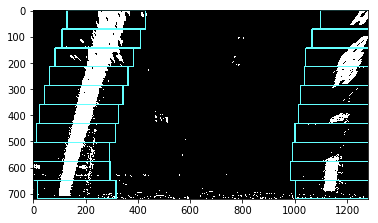

In [19]:
for window in range(nwindows):
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = current_left_peak - x_margin
    win_xleft_high = current_left_peak + x_margin
    win_xright_low = current_right_peak - x_margin
    win_xright_high = current_right_peak + x_margin
    
    cv2.rectangle(warped_3d,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
                  (100,255,255), 3) 
    cv2.rectangle(warped_3d,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
                  (100,255,255), 3)
    
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    if len(good_left_inds) > 1:
        current_left_peak = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > 1:        
        current_right_peak = np.int(np.mean(nonzerox[good_right_inds]))
    
plt.imshow(warped_3d)

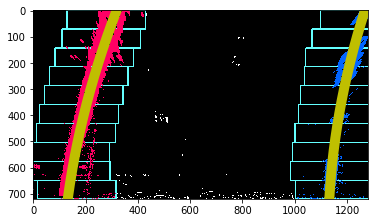

In [42]:
warped_3d_cp = np.copy(warped_3d)

left_a, left_b, left_c = [],[],[]
right_a, right_b, right_c = [],[],[]

left_lane_concat = np.concatenate(left_lane_inds)
right_lane_concat = np.concatenate(right_lane_inds)

leftx = nonzerox[left_lane_concat]
lefty = nonzeroy[left_lane_concat] 
rightx = nonzerox[right_lane_concat]
righty = nonzeroy[right_lane_concat]

left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

warped_3d_cp[nonzeroy[left_lane_concat], nonzerox[left_lane_concat]] = [255, 0, 100]
warped_3d_cp[nonzeroy[right_lane_concat], nonzerox[right_lane_concat]] = [0, 100, 255]

plt.imshow(warped_3d_cp)
plt.plot(left_fitx, ploty, c='y', linewidth=10)
plt.plot(right_fitx, ploty, c='y', linewidth=10)

In [44]:
color_img = np.zeros_like(img)

left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
points = np.hstack((left, right))
    
cv2.fillPoly(color_img, np.int_(points), (0,200,255))

src = np.float32([(0,0), (1, 0), (0,1), (1,1)])
src = src * np.float32((w, h))

M = cv2.getPerspectiveTransform(src, lanes)
inv_perspective = cv2.warpPerspective(color_img, M, (w, h))
inv_perspective = cv2.addWeighted(img, 1, inv_perspective, 0.7, 0)

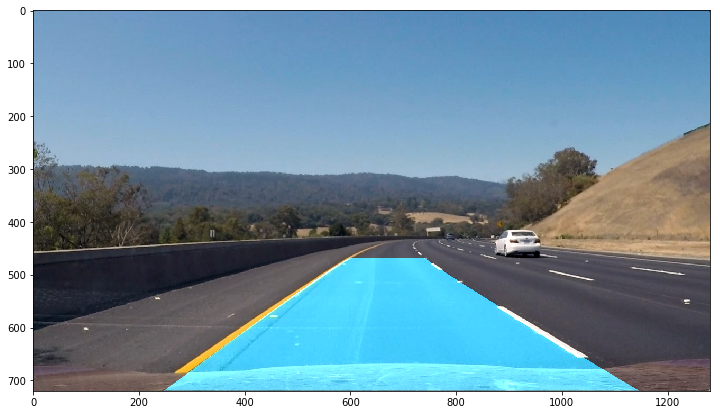

In [48]:
plt.figure(figsize = (15, 7))
plt.imshow(inv_perspective, cmap='hsv')
plt.show()